# LacZ/LacY model

Citation:
1. Kierzek, Andrzej M. 2002. “STOCKS: STOChastic Kinetic Simulations of Biochemical Systems with Gillespie Algorithm.” Bioinformatics 18 (3): 470–81. https://doi.org/10.1093/bioinformatics/18.3.470.
2. Tian, Tianhai, and Kevin Burrage. 2004. “Binomial Leap Methods for Simulating Stochastic Chemical Kinetics.” The Journal of Chemical Physics 121 (21): 10356–64. https://doi.org/10.1063/1.1810475.

Here are the non-trivial aspects of the modeled behavior:
- The cell volume is growing over time until it reaches a maximum at a fixed generation time, $T$ (t which point the cell will divide, a process that we ignore) such that $ V(t) = (1 + t/T) $. This generation time was set to be $2100$ seconds (Kierzek, 2002).

  - We note that none of the groups that benchmarked the performance of this system made mention of the fact that this explicit time dependence affects the validity of Gillespie's direct method (conventional SSA) and the approximate $\tau$-leaping method. (Since the STOCKS program is no longer available at the originally offered URL, it is challenging to confirm if the actual simulations were performed through a modified direct method). To account for this time dependence, the hitting time ($\tau$) of the overall stochastic process unfolding with rate $a_0(t)$ must be calculated implicity according to the following integral, in accordance with the fact that the arrivals occur through an inhomogeneous Poisson process rather than a homogeneous one:

$$ \int_{t_0}^{\tau} a_0(t) dt \sim \text{Exp}(1)$$

- The populations of two reactant species are treated specially: at all time steps, RNAP and Ribosome are drawn from random pools $N(35, 3.5^2)$ and $N(350, 35^2)$, respectively, and the means of these distributions grow with the volume of the cell so that their concentration remains fixed. This is intended to correspond to the assumption that the dynamics producing RNAP and Ribosome are much faster than the dynamics of the specified system, and that the dynamic equilibrium producing RNAP and Ribosome is unaffected by the behavior of the specified system (so that the concentration of RNAP and Ribosome remain unchanged).
  - Note: drawing from pools with growing means but constant variance does not seem to capture the desired behavior: if the concentration remains fixed in dynamic equilibrium, the molecular counts of RNAP and Ribosome in the cell should be growing in both mean *and* variance (see, for example, Gillespie's discussion of the mathematical basis for the Chemical Langevin equation).
  - Note also: that the randomly variable amounts of RNAP and Ribosome are important for a model of the real physical system, but they are incidental to the goal of benchmarking simulation approaches. Since we hope to compare the results of Gillespie simulation to the results of a variety of approximate simulations, it is sufficient to consider the concentrations RNAP and Ribosome to be fixed parameters of system rather than dynamically changing molecular counts. (Note: that fixing these concentrations will introduce time dependence inversely proportional the time dependence of the volume growth of the cell.) As long as the Gillespie simulation and the approximate simulations are conducted with respect to the same system, we can meainingfully compare results.

Gillespie on CLE
1. Gillespie, Daniel T. 2000. “The Chemical Langevin Equation.” The Journal of Chemical Physics 113 (1): 297–306. https://doi.org/10.1063/1.481811.


Citation inhomog Gillespie:
  1. Purtan, Raluca Roxana Purnichescu, and Andreea Udrea. 2013. “A Modified Stochastic Simulation Algorithm for Time-Dependent Intensity Rates.” In 2013 19th International Conference on Control Systems and Computer Science, 365–69. https://doi.org/10.1109/CSCS.2013.101.

In [1]:
import numba
from reactionmodel.model import Species, Reaction, Model
import numpy as np

In [2]:
LacZ = Species('LacZ')
LacY = Species('LacY')

PLac = Species('PLac')

PLacRNAP = Species('PLacRNAP')


TrLacZ1 = Species('TrLacZ1')
TrLacY1 = Species('TrLacY1')

TrLacZ2 = Species('TrLacZ2')
TrLacY2 = Species('TrLacY2')

RbsLacZ = Species('RbsLacZ')
RbsLacY = Species('RbsLacY')

TrRbsLacZ = Species('TrRbsLacZ')
TrRbsLacY = Species('TrRbsLacY')

dgrLacZ = Species('dgrLacZ')
dgrLacY = Species('dgrLacY')

dgrRbsLacZ = Species('dgrRbsLacZ')
dgrRbsLacY = Species('dgrRbsLacY')

RbsRibosomeLacZ = Species('RbsRibosomeLacZ')
RbsRibosomeLacY = Species('RbsRibosomeLacY')

LacZlactose = Species('LacZlactose')

lactose = Species('lactose')
product = Species('product')

species = [
    LacZ,
    LacY,
    PLac,
    PLacRNAP,
    TrLacZ1,
    TrLacY1,
    TrLacZ2,
    TrLacY2,
    RbsLacZ,
    RbsLacY,
    TrRbsLacZ,
    TrRbsLacY,
    dgrLacZ,
    dgrLacY,
    dgrRbsLacZ,
    dgrRbsLacY,
    RbsRibosomeLacZ,
    RbsRibosomeLacY,
    lactose,
    LacZlactose,
    product,
]

T = 2100

def make_V_dependent_rate(k):
    @numba.jit(nopython=True)
    def k_of_t(t):
        return k / (1 + t/T)
    return k_of_t

parameters = {
    'RNAP': 35,
    'Ribosome': 350,
}

reactions = [
    Reaction([PLac], [PLacRNAP], k='0.17 * RNAP'),
    Reaction([PLacRNAP], [PLac], k=10), # produces RNAP
    Reaction([PLacRNAP], [TrLacZ1], k=1),
    Reaction([TrLacZ1], [RbsLacZ, PLac, TrLacZ2], k=1),
    Reaction([TrLacZ2], [TrLacY1], k=0.015),
    Reaction([TrLacY1], [RbsLacY, TrLacY2], k=1),
    Reaction([TrLacY2], [], k=0.36), # produces RNAP
    Reaction([RbsLacZ], [RbsRibosomeLacZ], k='0.17 * Ribosome'),
    Reaction([RbsLacY], [RbsRibosomeLacY], k='0.17 * Ribosome'),
    Reaction([RbsRibosomeLacZ], [RbsLacZ], k=0.45), # produces Ribosome
    Reaction([RbsRibosomeLacY], [RbsLacY], k=0.45), # produces Ribosome
    Reaction([RbsRibosomeLacZ], [TrRbsLacZ, RbsLacZ], k=0.4),
    Reaction([RbsRibosomeLacY], [TrRbsLacY, RbsLacY], k=0.4),
    Reaction([TrRbsLacZ], [LacZ], k=0.015),
    Reaction([TrRbsLacY], [LacY], k=0.036),
    Reaction([LacZ], [dgrLacZ], k=6.42e-5),
    Reaction([LacY], [dgrLacY], k=6.42e-5),
    Reaction([RbsLacZ], [dgrRbsLacZ], k=0.3),
    Reaction([RbsLacY], [dgrRbsLacY], k=0.3),
    Reaction([LacZ, lactose], [LacZlactose], k=9.52e-5),#k=make_V_dependent_rate(9.52e-5)),
    Reaction([LacZlactose], [product, LacZ], k=431),
    Reaction([LacY], [lactose, LacY], k=14),
]

# but ribosome and RNAP are supposed to grow over time as volume of the cell decreases (which also affects rate constants of all second order rates, this seems too complicated for us!)

m = Model(species, reactions)

In [3]:
initial = {
    'PLac': 1,
}

In [4]:
y0 = m.make_initial_condition(initial)

## Simulation

In [5]:
from hybrid.gillespie import GillespieSimulator

simulator = GillespieSimulator(
    m.get_k(parameters=parameters, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
)

Evaluating expression: 0.17 * RNAP => 5.95
Evaluating expression: 0.17 * Ribosome => 59.50000000000001
Evaluating expression: 0.17 * Ribosome => 59.50000000000001


In [42]:
result = simulator.simulate([0, 200.0], y0, np.random.default_rng(), history_length=1e8)

In [43]:
extended = simulator.simulate([200.0, 205.0], result.y, np.random.default_rng(), history_length=1e8)

In [44]:
result.status_counter

Counter({<GillespieStepStatus.stochastic: 2>: 1516005})

In [45]:
extended.status_counter

Counter({<GillespieStepStatus.stochastic: 2>: 175676})

249.9157951881457

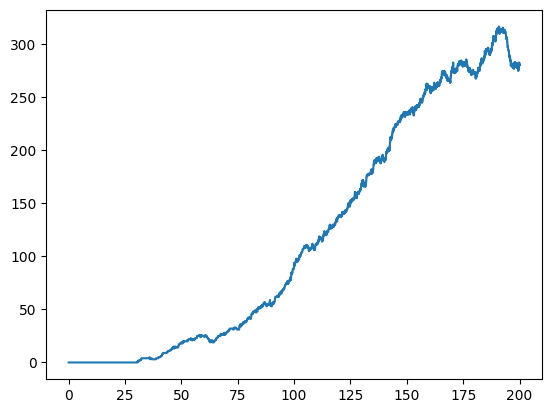

In [46]:
import matplotlib.pyplot as plt

s = TrRbsLacY
s_history = result.y_history[m.species.index(s), :]

plt.plot(result.t_history, s_history)
np.mean(s_history)

## Saving initial state

In [48]:
import yaml

In [31]:
m.save('./laczlacy/model.yaml')

In [49]:
advanced_initial_condition = {s.name: int(result.y[i]) for i,s in enumerate(m.species)}

with open('./laczlacy/initial.yaml', 'w') as f:
    yaml.dump(advanced_initial_condition, f, Dumper=yaml.SafeDumper)

In [34]:
with open('./laczlacy/parameters.yaml', 'w') as f:
    yaml.dump(parameters, f, Dumper=yaml.SafeDumper)

# Hybrid simulation

In [89]:
from hybrid.hybrid import HybridSimulator, NThresholdPartitioner

hybrid_simulator = HybridSimulator(
    m.get_k(parameters=parameters, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    partition_function=NThresholdPartitioner(50.0),
    fast_scale='langevin',
    approximate_rtot=True,
    contrived_no_reaction_rate=20.0,
)

Evaluating expression: 0.17 * RNAP => 5.95
Evaluating expression: 0.17 * Ribosome => 59.50000000000001
Evaluating expression: 0.17 * Ribosome => 59.50000000000001


In [90]:
hybrid_simulator.simulate([200, 205], result.y, np.random.default_rng())

History(t=204.99801930382014, y=array([1.23100e+03, 9.24000e+02, 0.00000e+00, 1.00000e+00, 0.00000e+00,
       0.00000e+00, 2.10000e+01, 1.00000e+00, 0.00000e+00, 0.00000e+00,
       8.42000e+02, 2.45000e+02, 4.00000e+00, 4.00000e+00, 2.20000e+01,
       1.40000e+01, 3.90000e+01, 2.60000e+01, 1.02068e+05, 2.50000e+01,
       5.24092e+05]), t_history=array([200.        , 200.        , 200.00005729, ..., 204.99791029,
       204.99791029, 204.9980193 ]), y_history=array([[1.18000e+03, 1.18000e+03, 1.17900e+03, ..., 1.23000e+03,
        1.23000e+03, 1.23100e+03],
       [8.31000e+02, 8.31000e+02, 8.31000e+02, ..., 9.24000e+02,
        9.24000e+02, 9.24000e+02],
       [1.00000e+00, 1.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [9.89750e+04, 9.89750e+04, 9.89750e+04, ..., 1.02068e+05,
        1.02068e+05, 1.02068e+05],
       [3.00000e+01, 3.00000e+01, 3.10000e+01, ..., 2.60000e+01,
        2.60000e+01, 2.50000e+01],
       [4.66867e+05, 